# Distribution of Accounts

The distribution of acccounts may help influence the result. Let's try to identify:

- "Super accounts" - e.g. one of the accounts is earmarked for eBay transactions.
- One-time customers - Customers who only purchased once may cloud the data.

## Libraries

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2  # 1 would be where you need to specify the files
#%aimport data_fcns

import pandas as pd # dataframes
import os
import gspread_pandas
from gspread_pandas import Spread, Client # gsheets interaction

# Data storage
from sqlalchemy import create_engine # SQL helper
import psycopg2 as psql #PostgreSQL DBs

# Custom
import data_fcns as dfc
import keys  # Custom keys lib

### Get transactions data

In [2]:
# Define path to secret
secret_path_aws = os.path.join(os.environ['HOME'], '.secret', 
                           'aws_ps_flatiron.json')
secret_path_aws

'/Users/werlindo/.secret/aws_ps_flatiron.json'

In [ ]:
aws_keys = keys.get_keys(secret_path_aws)
user = aws_keys['user']
ps = aws_keys['password']
host = aws_keys['host']
db = aws_keys['db_name']

aws_ps_engine = ('postgresql://' + user + ':' + ps + '@' + host + '/' + db)

In [121]:
# Setup PSQL connection
conn = psql.connect(
    database=db,
    user=user,
    password=ps,
    host=host,
    port='5432'
)

In [122]:
# Instantiate cursor
cur = conn.cursor()

In [123]:
#  Count records.
query = """
    SELECT
        account_num
        ,COUNT(DISTINCT comic_title) num_title_bought 
    FROM 
        comic_trans 
    GROUP BY
        account_num
    ORDER BY 
        2 DESC
    ;
"""

In [124]:
# Execute the query
cur.execute(query)

In [125]:
# Check results
temp_df = pd.DataFrame(cur.fetchall())
temp_df.columns = [col.name for col in cur.description]

In [126]:
temp_df.head(10)

,account_num,num_title_bought
0,00191,1504
1,00961,1114
2,01132,1023
3,01695,944
4,00134,925
5,00174,838
6,01047,730
7,01858,715
8,01275,694
9,00108,652


In [10]:
#  Count records.
query = """
    SELECT * from comic_trans limit 10;
"""

In [21]:
temp_df.tail(10)

,account_num,num_title_bought
1707,01217,1
1708,03011,1
1709,00902,1
1710,00911,1
1711,01630,1
1712,00313,1
1713,00926,1
1714,00931,1
1715,03015,1
1716,03016,1


In [22]:
temp_df.shape

(1717, 2)

- There are 1.7K accounts who bought at least 1 title  
- The top end doesn't seem as skewed as I thought it would, at least at first blush.

In [24]:
import seaborn as sns

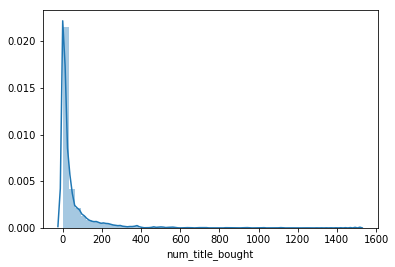

In [25]:
sns.distplot(temp_df.num_title_bought)

Well, don't really know what I meant by the prior comment re: skewness. I think what I mean is that my prior guess was that the 'top' account would number in the high thousands, though that was more of a, like I said, guess.

Could always just set up high and low thresholds, and just set them as get more info.

In [51]:
# Thresholds
bottom = 1
top = 100

In [52]:
small_df = temp_df.loc[(temp_df.num_title_bought > bottom) & (temp_df.num_title_bought < top)]

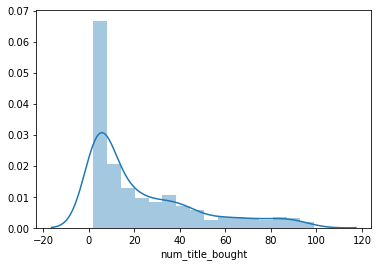

In [53]:
sns.distplot(small_df.num_title_bought)

In [54]:
small_df['num_title_bought'].value_counts().head(20)

2     125
3     108
4      76
6      51
7      40
5      39
8      36
9      36
10     34
11     27
12     23
18     20
35     19
19     17
13     15
20     15
37     15
23     14
27     14
15     14
Name: num_title_bought, dtype: int64

Definitely skewed. Just from visual inspection from playing around with the thresholds and looking at the `value_counts`, just set some arbitrary limits of:  
- bottom: 5
- top : 250

Let's create a table on our DB that is `account_num` by `num_title_bought`

In [59]:
#  Create account counts table.
query = """
    CREATE TABLE acct_cts AS
    SELECT
        account_num
        ,COUNT(DISTINCT comic_title) num_title_bought 
    FROM 
        comic_trans 
    GROUP BY
        account_num
    ;
"""

In [60]:
# Execute the query
cur.execute(query)

In [61]:
conn.commit()

Check it.

In [81]:
#  Count records.
query = """
    SELECT *
    FROM acct_cts
    --WHERE num_title_bought between 5 and 250
    WHERE num_title_bought > 250 
    ORDER BY num_title_bought DESC
    ;
"""

In [82]:
# Execute the query
cur.execute(query)

In [83]:
# Check results
temp_df = pd.DataFrame(cur.fetchall())
temp_df.columns = [col.name for col in cur.description]

In [84]:
temp_df

,account_num,num_title_bought
0,00191,1504
1,00961,1114
2,01132,1023
3,01695,944
4,00134,925
5,00174,838
6,01047,730
7,01858,715
8,01275,694
9,00108,652


Should we also subset on dates to control for tastes changing over time?

In [89]:
query = """
    SELECT * FROM comic_trans 
    WHERE date_sold >= '2018-01-01'
    limit 10;
"""

In [90]:
# Execute the query
cur.execute(query)

In [91]:
# Check results
temp_df = pd.DataFrame(cur.fetchall())
temp_df.columns = [col.name for col in cur.description]

In [92]:
temp_df

,index,publisher,item_id,title_and_num,qty_sold,date_sold,account_num,comic_title
0,471,Archie Comics,DCDL068591,Archie #27 Cvr A Mok,1,2018-01-17 12:07:25,02247,Archie (Archie)
1,472,Archie Comics,DCDL068591,Archie #27 Cvr A Mok,1,2018-01-19 12:18:23,01573,Archie (Archie)
2,473,Archie Comics,DCDL068591,Archie #27 Cvr A Mok,1,2018-01-21 10:28:06,00280,Archie (Archie)
3,474,Archie Comics,DCDL068591,Archie #27 Cvr A Mok,1,2018-01-18 17:02:55,02163,Archie (Archie)
4,475,Archie Comics,DCDL068591,Archie #27 Cvr A Mok,1,2018-01-12 14:18:12,00961,Archie (Archie)
5,476,Archie Comics,DCDL068591,Archie #27 Cvr A Mok,1,2018-01-18 17:57:15,00161,Archie (Archie)
6,477,Archie Comics,DCDL068591,Archie #27 Cvr A Mok,1,2018-02-22 13:43:41,02224,Archie (Archie)
7,478,Archie Comics,DCDL071881,Archie #28 Cvr A Mok,1,2018-02-26 17:36:16,02163,Archie (Archie)
8,479,Archie Comics,DCDL071881,Archie #28 Cvr A Mok,1,2018-02-18 10:05:33,00280,Archie (Archie)
9,480,Archie Comics,DCDL071881,Archie #28 Cvr A Mok,1,2018-02-16 14:49:33,02247,Archie (Archie)


Date filtering works. Super arbitrary? 
- Is there an effect from other pop culture influence:
- Marvel movies? (e.g. Iron Man 2008, Avengers 2012, etc)

I thnk safe for now is to just either take it all? or Just settle on some rule of thumb for now: e.g. 5 years.


## Conclusions
#### 2019.06.26 11am

- set minimum at 5
- set maximum at 250
- No date filter

In [127]:
min_titles = 5
max_titles = 250

In [128]:
query = """
    SELECT ct.* 
    FROM 
        comic_trans ct 
        INNER JOIN acct_cts ac on ct.account_num = ac.account_num
    WHERE
        ac.num_title_bought between {} and {};
""".format(min_titles, max_titles)

In [129]:
query

'\n    SELECT ct.* \n    FROM \n        comic_trans ct \n        INNER JOIN acct_cts ac on ct.account_num = ac.account_num\n    WHERE\n        ac.num_title_bought between 5 and 250;\n'

In [130]:
# Execute the query
cur.execute(query)

In [131]:
# Check results
temp_df = pd.DataFrame(cur.fetchall())
temp_df.columns = [col.name for col in cur.description]

conn.rollback()

In [132]:
temp_df.head()

,index,publisher,item_id,title_and_num,qty_sold,date_sold,account_num,comic_title
0,5,Amaze Ink Slave Labor Graphics,DCD416182,Royal Historian of Oz #1,1,2010-07-14 19:49:40,00399,Royal Historian of Oz (SLG)
1,7,Amaze Ink Slave Labor Graphics,DCD416182,Royal Historian of Oz #1,1,2010-10-31 16:38:39,00327,Royal Historian of Oz (SLG)
2,9,Amaze Ink Slave Labor Graphics,DCD423794,Royal Historian of Oz #2,1,2010-10-31 16:38:39,00327,Royal Historian of Oz (SLG)
3,12,Amaze Ink Slave Labor Graphics,DCD390709,Warlord of Io & Other Stories,1,2014-10-01 12:24:07,01065,Warlord of Io & Other Storie (SLG)
4,13,Archie Comics,DCD630105,Afterlife With Archie #1 2nd P,1,2014-01-23 19:36:29,01033,Afterlife With Archie (Archie)


In [133]:
temp_df.shape

(287234, 8)

In [134]:
287/490 - 1 

-0.41428571428571426

Doing that filter would reduce our starting dataset by about 40%. Let's go with it and see what it looks like.

# Create Smaller Dataset

Latest instance of the target table is `temp_df`. So just run with that.

Drop `index`

In [135]:
temp_df = temp_df.drop(['index'], axis=1)

In [137]:
temp_df.head()

,publisher,item_id,title_and_num,qty_sold,date_sold,account_num,comic_title
0,Amaze Ink Slave Labor Graphics,DCD416182,Royal Historian of Oz #1,1,2010-07-14 19:49:40,00399,Royal Historian of Oz (SLG)
1,Amaze Ink Slave Labor Graphics,DCD416182,Royal Historian of Oz #1,1,2010-10-31 16:38:39,00327,Royal Historian of Oz (SLG)
2,Amaze Ink Slave Labor Graphics,DCD423794,Royal Historian of Oz #2,1,2010-10-31 16:38:39,00327,Royal Historian of Oz (SLG)
3,Amaze Ink Slave Labor Graphics,DCD390709,Warlord of Io & Other Stories,1,2014-10-01 12:24:07,01065,Warlord of Io & Other Storie (SLG)
4,Archie Comics,DCD630105,Afterlife With Archie #1 2nd P,1,2014-01-23 19:36:29,01033,Afterlife With Archie (Archie)


In [140]:
temp_df.to_json('raw_data/trans_filtered.json', orient='records', lines=True)

In [141]:
!head raw_data/trans_filtered.json

{"publisher":"Amaze Ink Slave Labor Graphics","item_id":"DCD416182","title_and_num":"Royal Historian of Oz #1","qty_sold":1,"date_sold":1279136980000,"account_num":"00399","comic_title":"Royal Historian of Oz (SLG)"}
{"publisher":"Amaze Ink Slave Labor Graphics","item_id":"DCD416182","title_and_num":"Royal Historian of Oz #1","qty_sold":1,"date_sold":1288543119000,"account_num":"00327","comic_title":"Royal Historian of Oz (SLG)"}
{"publisher":"Amaze Ink Slave Labor Graphics","item_id":"DCD423794","title_and_num":"Royal Historian of Oz #2","qty_sold":1,"date_sold":1288543119000,"account_num":"00327","comic_title":"Royal Historian of Oz (SLG)"}
{"publisher":"Amaze Ink Slave Labor Graphics","item_id":"DCD390709","title_and_num":"Warlord of Io & Other Stories","qty_sold":1,"date_sold":1412166247000,"account_num":"01065","comic_title":"Warlord of Io & Other Storie (SLG)"}
{"publisher":"Archie Comics","item_id":"DCD630105","title_and_num":"Afterlife With Archie #1 2nd P","qty_sold":1,"date_s